In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.16.1
GPU Available: []


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
df = pd.read_csv(r"C:\Users\ya070\OneDrive\Desktop\stock project\Stock\preprocessing\merged_dataset.csv")

# Drop date column
features = df.drop(columns=["date"])

# Separate target (close price)
target = features["close"].values.reshape(-1, 1)
features = features.drop(columns=["close"])

# Split BEFORE scaling to avoid data leakage
train_size = int(0.8 * len(features))
train_features, test_features = features.iloc[:train_size], features.iloc[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

In [5]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_test_features = feature_scaler.transform(test_features)

scaled_train_target = target_scaler.fit_transform(train_target)
scaled_test_target = target_scaler.transform(test_target)

# Merge back for sequence creation
scaled_train_df = np.concatenate([scaled_train_features, scaled_train_target], axis=1)
scaled_test_df = np.concatenate([scaled_test_features, scaled_test_target], axis=1)

In [6]:
def create_sequences(data, target_col, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, target_col])
    return np.array(X), np.array(y)

target_col = scaled_train_df.shape[1] - 1  # target index (last column)

X_train, y_train = create_sequences(scaled_train_df, target_col, window_size=60)
X_test, y_test = create_sequences(scaled_test_df, target_col, window_size=60)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (438, 60, 12)
y_train shape: (438,)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# ======================
# Optimized BiLSTM Model
# ======================
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    # 1st BiLSTM layer
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))),
    LayerNormalization(),
    Dropout(0.4),

    # 2nd BiLSTM layer
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001))),
    LayerNormalization(),
    Dropout(0.3),

    # Dense layers
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 60, 128)             │          39,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 60, 128)             │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,297 (341.00 KB)

 Trainable params: 87,297 (341.00 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,               # more patience before stopping
    restore_best_weights=True,
    verbose=1
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-5,
    verbose=1
)

In [20]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,               # allow full training
    batch_size=16,            # smaller batch => better generalization
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 241ms/step - loss: 0.6257 - val_loss: 1.0468 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.4813 - val_loss: 0.8918 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.4417 - val_loss: 0.8460 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.4035 - val_loss: 0.8487 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.3829 - val_loss: 0.8261 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.3677 - val_loss: 0.8626 - learning_rate: 0.0010
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.3458 - val_loss: 0.7994 - learning_rate: 0.0010
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.3256 - val_loss: 0.8009 - learning_rate: 0.0010
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.3104 - val_loss: 0.7615 - learning_rate: 0.0010
E

In [21]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
corr = np.corrcoef(y_test.flatten(), y_pred.flatten())[0, 1]
accuracy = corr * 100

print("\nScaled Evaluation Metrics:")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Accuracy: {accuracy:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 615ms/step

Scaled Evaluation Metrics:
MSE: 0.429354
MAE: 0.583976
R² Score: 0.388849
Accuracy: 95.04%


In [22]:
# Inverse Transform
# ======================
y_pred_inv = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
corr = np.corrcoef(y_test_inv.flatten(), y_pred_inv.flatten())[0, 1]
accuracy = corr * 100

print("\nDescaled Evaluation Metrics:")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Accuracy: {accuracy:.2f}%")


Descaled Evaluation Metrics:
MSE: 143266.620029
MAE: 337.333463
R² Score: 0.388849
Accuracy: 95.04%


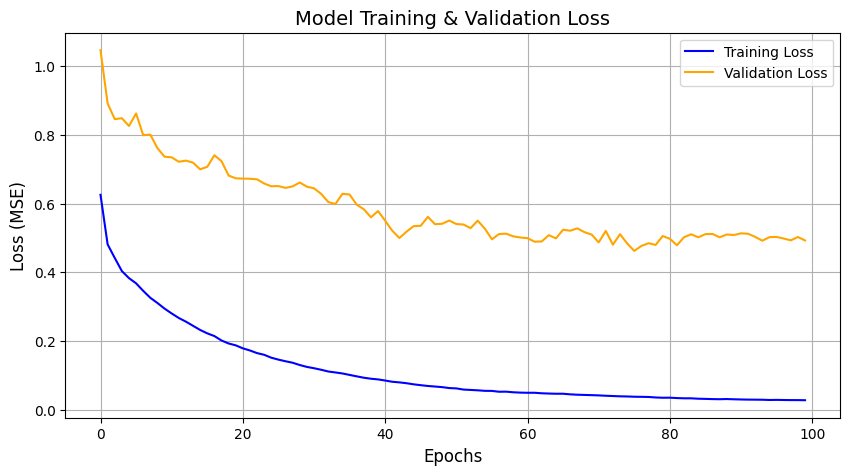

In [24]:
# Plot: Model Training & Validation Loss
# ======================
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Training & Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


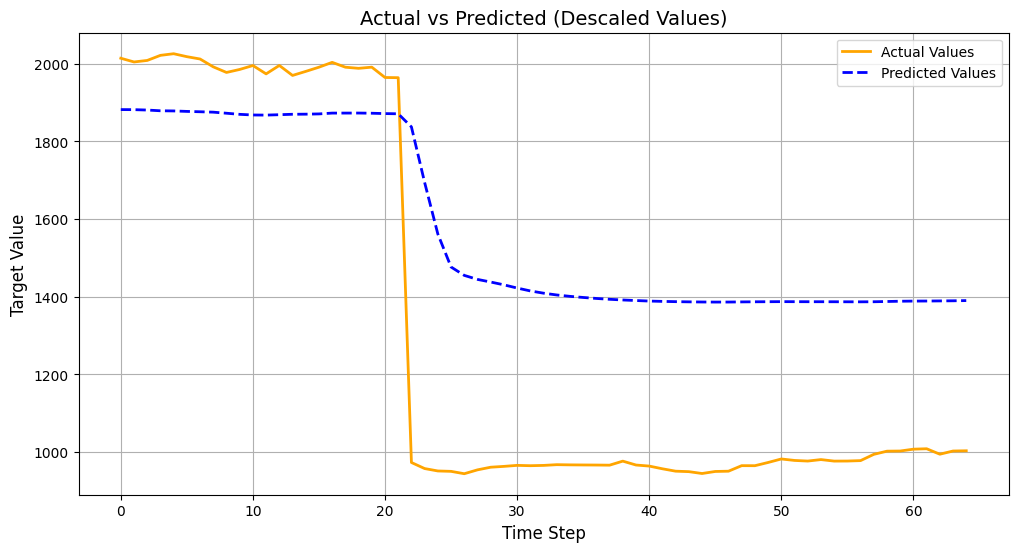

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Values', color='orange', linewidth=2)
plt.plot(y_pred_inv, label='Predicted Values', color='blue', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted (Descaled Values)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [33]:
os.makedirs("final", exist_ok=True)

# Save model
model.save("final/bilstm_stock_model.h5")
print(" Model saved to final/bilstm_stock_model.h5")

# Save predictions
output_df = pd.DataFrame({
    "Actual_Close": y_test_inv.flatten(),
    "Predicted_Close": y_pred_inv.flatten()
})
output_df.to_csv("final/bilstm_predictions.csv", index=False)
print(" Predictions saved to final/bilstm_predictions.csv")

# Save scaled dataset for reproducibility
scaled_full_df = np.concatenate([
    feature_scaler.transform(features),
    target_scaler.transform(target)
], axis=1)
scaled_full_df = pd.DataFrame(scaled_full_df, columns=list(features.columns) + ["close"])
scaled_full_df.to_csv("final/scaled_stock_dataset.csv", index=False)
print("Scaled dataset saved to final/scaled_stock_dataset.csv")


#  Descaled Dataset

descaled_features = feature_scaler.inverse_transform(feature_scaler.transform(features))
descaled_target = target_scaler.inverse_transform(target_scaler.transform(target))
descaled_full = np.concatenate([descaled_features, descaled_target], axis=1)

descaled_df = pd.DataFrame(descaled_full, columns=list(features.columns) + ["close"])
descaled_df.to_csv("final/descaled_stock_dataset.csv", index=False)
print(" Descaled dataset saved to final/descaled_stock_dataset.csv")

 Model saved to final/bilstm_stock_model.h5
 Predictions saved to final/bilstm_predictions.csv
Scaled dataset saved to final/scaled_stock_dataset.csv
 Descaled dataset saved to final/descaled_stock_dataset.csv
